## Intended for others to play with the code

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np


import torch
from torch import nn
import torch.nn.functional as F

from cont_speech_experiment import ContinuousSpeechExperiment, ClasswiseDataset
from nupic.research.support import parse_config

from nupic.research.frameworks.continuous_learning.utils import clear_labels, freeze_output_layer
from exp_lesparse import LeSparseNet

import os

from nupic.research.frameworks.pytorch.model_utils import evaluate_model
from nupic.research.frameworks.continuous_learning.dendrite_layers import (
    DendriteLayer, DendriteInput, DendriteOutput
)
from nupic.torch.modules import (
    Flatten,
    KWinners,
    KWinners2d,
    SparseWeights,
    SparseWeights2d,
)

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
config_file = "experiments.cfg"
with open(config_file) as cf:
    config_init = parse_config(cf)
    
exp = "sparseCNN2"

config = config_init[exp]
config["name"] = exp
config["use_dendrites"] = True
config["use_batch_norm"] = False
config["cnn_out_channels"] = (64, 64)
config["cnn_percent_on"] = (0.12, 0.07)
config["cnn_weight_sparsity"] = (0.15, 0.05)
config["dendrites_per_cell"] = 2
config["batch_size"] = 64
experiment = ContinuousSpeechExperiment(config=config)

Creating optimizer with learning rate= 0.01


In [3]:
def get_no_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

def clear_labels(labels, n_classes=5):
    indices = np.arange(n_classes)
    out = np.delete(indices, labels)
    return out

def reshape_xs(data, target, device=torch.device("cuda"), non_blocking=None):
    # for evaluate_model if you flatten the images
    batch_size = data.shape[0]
    data = data.reshape(batch_size, 32*32).to(device)
    target = target.to(device)
    return data, target

In [42]:
class ToyNetwork(nn.Module):
    def __init__(self, dpc=3,
                 cnn_w_sparsity=0.05,
                 linear_w_sparsity=0.5,
                 cat_w_sparsity=0.01,
                n_classes=4,
                do_cat=False):
        super(ToyNetwork, self).__init__()
        conv_channels = 128
        self.n_classes = n_classes
        self.do_cat = do_cat
        self.conv1 = SparseWeights2d(nn.Conv2d(in_channels=1,
                                              out_channels=conv_channels,
                                              kernel_size=10,
                                              padding=0,
                                              stride=1,), cnn_w_sparsity)
        self.kwin1 = KWinners2d(conv_channels, percent_on=0.1)
        self.bn = nn.BatchNorm2d(conv_channels, affine=False)
        self.mp1 = nn.MaxPool2d(kernel_size=2)
        self.flatten = Flatten()
        
        self.d1 = DendriteLayer(in_dim=int(conv_channels/64)*7744,
                               out_dim=1000,
                               dendrites_per_neuron=dpc)
        
        self.linear = SparseWeights(nn.Linear(1000, n_classes+1), linear_w_sparsity)
        
        if self.do_cat:
            self.cat = SparseWeights(nn.Linear(n_classes+1, 1000*dpc), cat_w_sparsity)
        
    def forward(self, x, label=None, batch_norm=False):
        y = self.conv1(x)
        if batch_norm:
            y = self.bn(y)
        y = self.kwin1(self.mp1(y))
        y = self.flatten(y)
        if (label is not None) and (self.do_cat == True) :
            yhat = torch.eye(self.n_classes+1)[label]
            y = self.d1(y, torch.sigmoid(self.cat(yhat.cuda())))
        else:
            y = self.d1(y)
        y = F.log_softmax(self.linear(y), dim=1)
        return y

In [47]:
net = ToyNetwork(dpc=4, cat_w_sparsity=0.01).cuda()

In [48]:
opt = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=0.)
criterion = F.nll_loss

In [49]:
train_inds = np.arange(1,5).reshape(2,2)
losses = []
for i in range(len(train_inds)):
    experiment.combine_classes(train_inds[i])
    loader = experiment.train_loader
    for j, (x, y) in enumerate(loader):
        batch_size = x.shape[0]
        opt.zero_grad()
       
        out = net(x.cuda()) #  no categorical projection
#         out = net(x.cuda(), y.cuda()) # categorical projection
        loss = criterion(out, y.cuda())
        loss.backward()
        losses.append(loss.detach().cpu().numpy())
        
        freeze_output_layer(net, clear_labels(train_inds),
                           layer_type="kwinner", linear_number='')
        
        opt.step()
    print([evaluate_model(net, experiment.test_loader[k], torch.device("cuda"))["mean_accuracy"]
           for k in train_inds[i]])

[0.9635416666666666, 0.84375]
[0.9765625, 0.7578125]


In [50]:
# test on each class trained sequentially 
[evaluate_model(net, experiment.test_loader[k], torch.device("cuda"))["mean_accuracy"] for k in train_inds.flatten()]

[0.0, 0.0, 0.9765625, 0.7578125]

### Some results

In [303]:
# Adam, dpc=4, cat sparsity=0.01, output freezing, output_size=5
[evaluate_model(net, experiment.test_loader[k], torch.device("cuda"))["mean_accuracy"] for k in train_inds.flatten()]

[0.2808988764044944, 0.04924242424242424, 0.684, 0.0]

In [308]:
# Same
[evaluate_model(net, experiment.test_loader[k], torch.device("cuda"))["mean_accuracy"] for k in train_inds.flatten()]

[0.0, 0.007575757575757576, 0.872, 0.31048387096774194]

In [295]:
np.log10(get_no_params(net))

7.5186314861691

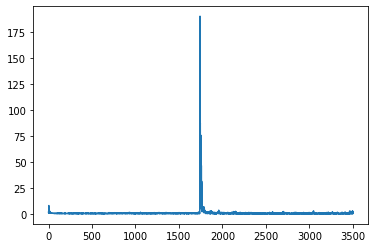

In [304]:
plt.plot(losses)

In [213]:
# Adam, dpc=4, tanh cat fn, output freezing, output_size=5
[evaluate_model(net, experiment.test_loader[k], torch.device("cuda"))["mean_accuracy"] for k in train_inds.flatten()]

[0.0, 0.4838709677419355, 0.28, 0.50187265917603]

In [207]:
# Adam, dpc=4, tanh cat fn, no freezing, output_size=5
[evaluate_model(net, experiment.test_loader[k], torch.device("cuda"))["mean_accuracy"] for k in train_inds.flatten()]

[0.20973782771535582, 0.0, 0.468, 0.4166666666666667]

In [154]:
# dpc = 1, SGD lr=0.1, # no cat act_fn, no output freezing, output_size=11
[evaluate_model(net, experiment.test_loader[k], torch.device("cuda"))["mean_accuracy"] for k in train_inds.flatten()]

[0.0, 0.7651515151515151, 0.0, 0.14516129032258066]

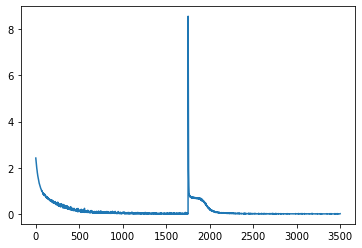

In [155]:
plt.plot(losses)

In [127]:
[evaluate_model(net, experiment.test_loader[k], torch.device("cuda"))["mean_accuracy"] for k in range(4)]

[0, 0.616, 0.0, 0.38257575757575757]

In [4]:
class LinearToyNetwork(nn.Module):
    """ Using dendrite layers for input
    Note you will have to adjust the training loop a bit
    to accomodate the image flattening
    """
    def __init__(self, dpc=3,
                 linear1_w_sparsity=0.5,
                 linear2_w_sparsity=0.1,
                 cat_w_sparsity=0.01,
                n_classes=4,
                batch_norm=True):
        super(ToyNetwork, self).__init__()
        linear1_channels = 1000
        linear2_channels=512
        self.batch_norm = batch_norm
        
        self.n_classes = n_classes
        self.linear1 = SparseWeights(nn.Linear(32*32, linear1_channels), linear1_w_sparsity)
        self.kwin1 = KWinners(linear1_channels, percent_on=0.1)
        self.bn = nn.BatchNorm1d(linear1_channels, affine=False)
                
        self.d0 = DendriteLayer(in_dim=32*32,
                               out_dim=linear1_channels,
                               dendrites_per_neuron=dpc,
                                act_fun_type="kwinner",
                               )       
        self.d1 = DendriteLayer(in_dim=linear1_channels,
                               out_dim=linear2_channels,
                               dendrites_per_neuron=dpc,
                                act_fun_type="kwinner",
                               )
        
        self.d2 = DendriteLayer(in_dim=linear2_channels,
                               out_dim=n_classes+1,
                               dendrites_per_neuron=dpc,
                               act_fun_type="None",
                               )
        self.cat = SparseWeights(nn.Linear(n_classes+1, linear1_channels*dpc), cat_w_sparsity)
        
        self.kwind1 = KWinners(linear2_channels, percent_on=0.1)
        self.kwind2 = KWinners(n_classes+1, percent_on=0.1)
        
    def forward(self, x, label=None, batch_norm=False):
#         y = self.linear1(x)
        y = self.d0(x)
        if self.batch_norm:
            y = self.bn(y)
        y = self.kwin1(y)
        if label is not None:
            yhat = torch.eye(self.n_classes+1)[label]
            y_ = self.cat(yhat.cuda())
            print(y_.shape)
            y = self.d1(y, torch.sigmoid(y_))
        else:
            y = self.d1(y)
        
        y = self.kwind1(y)
        y = self.kwind2(self.d2(y))
        y = F.log_softmax(y, dim=1)
        return y